In [1]:
import datetime
import pytz
import copy
import glob
import os
import math 
import enum

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import mplfinance as mpf
from stock_indicators import indicators
from stock_indicators.indicators.common.quote import Quote

# Загрузка данных

In [2]:
#path = "data\\2024-GDM4"
path = "data\\2024-GDU4"

all_files = glob.glob(os.path.join(path, "*.csv"))
ticker_data = pd.concat((pd.read_csv(f, 
                            delimiter=";",
                            usecols=[1,2,3,4,5,6], 
                            names=['UTC', 'open', 'close','high','low','volume'],
                            dtype = {'UTC': 'str', 
                                      'open': 'float', 
                                      'close': 'float', 
                                      'high': 'float',
                                      'low': 'float',
                                      'volume': 'int'},
                            parse_dates=['UTC']
                           ) 
                for f in all_files), ignore_index=True)
ticker_data.index = pd.DatetimeIndex(ticker_data['UTC'])
ticker_data.drop(['UTC'], axis=1, inplace=True)

In [3]:
len(ticker_data)

87161

In [4]:
ticker_data

,open,close,high,low,volume
UTC,,,,,
2024-01-03 06:16:00+00:00,2156.7,2156.7,2156.7,2156.7,1
2024-01-03 06:20:00+00:00,2156.6,2156.6,2156.6,2156.6,1
2024-01-03 07:12:00+00:00,2153.0,2153.0,2153.0,2153.0,1
2024-01-03 07:28:00+00:00,2153.1,2153.1,2153.1,2153.1,1
2024-01-03 08:09:00+00:00,2152.1,2152.3,2152.3,2152.1,3
...,...,...,...,...,...
2024-09-20 10:54:00+00:00,2590.6,2590.6,2590.6,2590.6,1
2024-09-20 10:55:00+00:00,2590.6,2590.6,2590.6,2590.6,136
2024-09-20 10:57:00+00:00,2590.5,2590.6,2590.6,2590.5,4


# Описание стратегии

In [5]:
class StrategySignal(enum.Enum):
    NO = 1
    BULL = 2
    BEAR = 3

In [6]:
class StrategyCommand(enum.Enum):
    HOLD = 1
    BUY = 2
    SELL = 3
    CLOSE = 4
    STOP_LOSS = 5

In [7]:
class Strategy:
    
    # конфигурация
    frame_size = 60
    fractal_in_enabled  = True
    fractal_out_enabled = True
    fractal_size = 4
    
    def __init__(self):
        
        return

    # Расчет индикаторов
    def calc_indicators(self, data ):
        quotes = [Quote(d,o,h,l,c,v) for d,o,h,l,c,v in zip(data.index, data['open'], data['high'], data['low'], data['close'], data['volume'])]
        alligator = indicators.get_alligator(quotes)
        fractal = indicators.get_fractal(quotes, self.fractal_size)
        result = data.copy()
        result["jaw"] = [ a.jaw for a in alligator]
        result["teeth"] = [ a.teeth for a in alligator]
        result["lips"] = [ a.lips for a in alligator]
        result["fractal_bear"] = [ f.fractal_bear if f.fractal_bear != None else np.nan for f in fractal]
        result["fractal_bull"] = [ f.fractal_bull if f.fractal_bull != None else np.nan for f in fractal]

        #i = 0
        #for f in fractal:
        #    if f.fractal_bear != None or f.fractal_bull != None:
        #        raise Exception(len(fractal), i, self.fractal_size, result["fractal_bear"], result["fractal_bull"])
        #    i += 1
        
        return result

    # helper
    def get_params(self,data):
        
        index = data.tail(1).index[0]
        prev_index = data.tail(2).index[0]
        fractal_index = data.tail(self.fractal_size+1).index[0]
        return (
                index,
                data.at[index, 'open'], 
                data.at[index, 'close'],
                data.at[index, 'high'],
                data.at[index, 'low'],
                data.at[index, 'volume'],

                data.at[index, 'jaw'  ] if data.at[index, 'jaw'  ] != None else np.nan,
                data.at[index, 'teeth'] if data.at[index, 'teeth'] != None else np.nan,
                data.at[index, 'lips' ] if data.at[index, 'lips' ] != None else np.nan,

                data.at[prev_index, 'jaw'  ] if data.at[prev_index, 'jaw'  ] != None else np.nan,
                data.at[prev_index, 'teeth'] if data.at[prev_index, 'teeth'] != None else np.nan,
                data.at[prev_index, 'lips' ] if data.at[prev_index, 'lips' ] != None else np.nan,

                data.at[fractal_index, 'fractal_bear'],
                data.at[fractal_index, 'fractal_bull']
           )
    
    # обработка шага стратегии
    def next(self, position, stop_loss, data):

        
        #инициализация локальных переменных
        indicators = self.calc_indicators(data)
        (
            time,   open_,  close,   high,   low,   volume,   
            jaw,   teeth,   lips,   
            prev_jaw,   prev_teeth,   prev_lips,
            fractal_bear,   fractal_bull
        )   = self.get_params(indicators)

        
        last_row = indicators.tail(1).copy()
        last_row.loc[ last_row.index[0], 'fractal_bull'] = fractal_bull 
        last_row.loc[ last_row.index[0], 'fractal_bear'] = fractal_bear

        
        
        # прерываем исполнение, если недостаточно данных
        if ( math.isnan(jaw) or 
             math.isnan(teeth) or 
             math.isnan(lips) or
             volume == 0 
            #or len(indicators.index) < self.frame_size
           ):
            return StrategyCommand.HOLD, stop_loss, last_row

        
        #Определяем состояние индикатора аллигатора
        if   (
            # проверяем главное условие аллигатора
            close > lips and lips > teeth and lips > jaw 
            # проверяем, что условие наступило только на текущем баре, а не сохраняется уже давно
            and (
                lips >= low  
                or not (prev_lips > prev_teeth and prev_lips > prev_jaw)
                or math.isnan(prev_jaw)
            )
            # проверяем доп. условие входа по пробитию уровня, чтобы отсечь мелкие тренды
            and (
                not self.fractal_in_enabled
                or indicators['fractal_bear'].sum() > 0 and np.nanmin(indicators['fractal_bear']) < close
            )
        ):    
            alligator_signal = StrategySignal.BULL
        
        elif (
            # проверяем главное условие аллигатора
            close < lips and lips < teeth and lips < jaw 
            # проверяем, что условие наступило только на текущем баре, а не сохраняется уже давно
            and (
                lips <= high 
                or not (prev_lips < prev_teeth and prev_lips < prev_jaw)
                or math.isnan(prev_jaw)
            )
            # проверяем доп. условие входа по пробитию уровня, чтобы отсечь мелкие тренды
            and (
                not self.fractal_in_enabled
                or indicators['fractal_bull'].sum() > 0 and np.nanmax(indicators['fractal_bull']) > close
            )
            
        ):
            alligator_signal = StrategySignal.BEAR
        
        else:
            alligator_signal = StrategySignal.NO
     
        
        # ищем точку входа
        if ( position == 0 ):

            #лонгуем
            if   (alligator_signal == StrategySignal.BULL): 
                stop_loss = lips
                return StrategyCommand.BUY, stop_loss, last_row
                    
            #шортим
            elif (alligator_signal == StrategySignal.BEAR):
                stop_loss = lips
                return StrategyCommand.SELL, stop_loss, last_row
        
        
        #Проверяем выход из лонга    
        elif( position > 0 ):
            
            # выход по условиям
            if( 
                close < lips 
                or (not math.isnan(fractal_bear) and self.fractal_out_enabled) 
            ):
                return StrategyCommand.CLOSE, stop_loss, last_row
            else:
                stop_loss = max(stop_loss, lips)

        
        #проверяем выход из шорта
        elif ( position < 0 ):
        
            # выход по условиям
            if( 
                close > lips 
                or (not math.isnan(fractal_bull) and self.fractal_out_enabled) 
            ):
                return StrategyCommand.CLOSE, stop_loss, last_row
            else:
                stop_loss = min( stop_loss, lips)
        
        return StrategyCommand.HOLD, stop_loss, last_row 

# Моделирование торговли

In [8]:
processig_data = ticker_data

#2024-GDM4
#processig_data = ticker_data['2024-03-01 00:00:00':'2024-06-01 00:00:00']
#processig_data = ticker_data['2024-05-03 00:00:00':'2024-05-09 00:00:00']

#2024-GDU4
processig_data = ticker_data['2024-06-01 00:00:00':'2024-09-01 00:00:00']
#processig_data = ticker_data['2024-08-04 00:00:00':'2024-08-07 00:00:00']

In [9]:
len(processig_data)

50489

In [11]:
points = 0      # количесво выйграных пунктов цены
position = 0    # количество преобретенного инструмента
enter_price = 0
stop_loss = 0
bull_deals = 0
bear_deals = 0
rows = []
points_log = []
bear_stop_loss = []
bull_stop_loss = []
no_stop_loss   = []
deals_in  = []
deals_out = []

end_stock_time = datetime.time(hour=21)
end_deals_before   = (datetime.datetime.combine(datetime.date(1,1,1),end_stock_time) + datetime.timedelta(hours=-1   )).time()
close_deals_before = (datetime.datetime.combine(datetime.date(1,1,1),end_stock_time) + datetime.timedelta(minutes=-10)).time()

# подготавливаем данные по дням
days_data = [group[1] for group in processig_data.groupby(processig_data.index.date)]

# запускаем цикл по дням
strategy = Strategy()
for day_data in days_data:
    bull_deals_day = 0
    bear_deals_day = 0
    
    # эмитация торговли внутри дня
    for index in day_data.index:
        target_loc = day_data.index.get_loc(index)
        start_loc = max(0, target_loc - strategy.frame_size)
        curient_frame = day_data.iloc[start_loc:target_loc + 1]
        low   = curient_frame['low'  ].iloc[-1]
        high  = curient_frame['high' ].iloc[-1]
        close = curient_frame['close'].iloc[-1]
        deal_in  = np.nan
        deal_out = np.nan

        # выход по лимиту
        if(   position > 0 and stop_loss > low ):
            position = 0 
            points += stop_loss - enter_price
            bull_deals += 1
            deal_out = stop_loss
        elif( position < 0 and stop_loss < high ):
            position = 0 
            points += enter_price - stop_loss
            bear_deals += 1
            deal_out = stop_loss

        # получаем команду от стратегии
        command, stop_loss, row = strategy.next(position, stop_loss, curient_frame)

        # Если нужно, выполняем закрытие позиций
        if(   command == StrategyCommand.BUY  and index.time() < end_deals_before ):
            enter_price = close
            position = 1
            deal_in = stop_loss
        elif( command == StrategyCommand.SELL and index.time() < end_deals_before ):
            enter_price = close
            position = -1
            deal_in = stop_loss
        elif( position > 0 and (command == StrategyCommand.CLOSE or index.time() > close_deals_before) ):
            points += close - enter_price
            position = 0 
            bull_deals_day += 1
            deal_out = stop_loss
        elif( position < 0  and (command == StrategyCommand.CLOSE or index.time() > close_deals_before) ):
            points += enter_price - close
            position = 0 
            bear_deals_day += 1
            deal_out = stop_loss

        # заносим промежуточные параметры в массивы
        rows += [row]
        points_log += [points]
        bull_stop_loss += [ stop_loss if position >  0 else np.nan ]
        bear_stop_loss += [ stop_loss if position <  0 else np.nan ]
        no_stop_loss   += [ row['lips'].iloc[0] if position == 0 else np.nan ]
        deals_in  += [deal_in]
        deals_out += [deal_out]

    bull_deals += bull_deals_day
    bear_deals += bear_deals_day
    
    #выводим результаты на конец очереднго дня
    print(day_data.index[0].date().isoformat(), 
          "bars:", len(day_data.index), 
          "points:", points, 
          "bull_deals_day:", bull_deals_day, 
          "bear_deals_day:", bear_deals_day)

processed_data = pd.concat(rows)
processed_data['points'        ] = points_log
processed_data['bull_stop_loss'] = bull_stop_loss
processed_data['bear_stop_loss'] = bear_stop_loss
processed_data['no_stop_loss'  ] =   no_stop_loss
processed_data['deals_in'      ] = deals_in
processed_data['deals_out'     ] = deals_out

2024-06-03 bars: 664 points: -1.7000310893854476 bull_deals_day: 8 bear_deals_day: 2
2024-06-04 bars: 580 points: 7.040663733549536 bull_deals_day: 5 bear_deals_day: 7
2024-06-05 bars: 599 points: -0.800863124625721 bull_deals_day: 8 bear_deals_day: 5
2024-06-06 bars: 648 points: 7.40230089679244 bull_deals_day: 7 bear_deals_day: 6
2024-06-07 bars: 816 points: 32.60412494383627 bull_deals_day: 3 bear_deals_day: 17
2024-06-10 bars: 725 points: 32.25522575357991 bull_deals_day: 6 bear_deals_day: 3
2024-06-11 bars: 738 points: 35.02649953847231 bull_deals_day: 6 bear_deals_day: 1
2024-06-13 bars: 714 points: 51.820686253839085 bull_deals_day: 2 bear_deals_day: 3
2024-06-14 bars: 728 points: 55.96501584500993 bull_deals_day: 7 bear_deals_day: 7
2024-06-17 bars: 733 points: 65.31544111918265 bull_deals_day: 7 bear_deals_day: 4
2024-06-18 bars: 763 points: 56.15813685494959 bull_deals_day: 7 bear_deals_day: 8
2024-06-19 bars: 754 points: 57.540345685175 bull_deals_day: 4 bear_deals_day: 8
20

C:\Users\ЕА\AppData\Local\Temp\ipykernel_10940\2535713029.py:93: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  processed_data = pd.concat(rows)


# Оценка результатов тестирования

In [12]:
leverage = 8

In [13]:
print("#### frame_size:", strategy.frame_size,  "fractal_in_enabled:", strategy.fractal_in_enabled, "fractal_out_enabled:", strategy.fractal_out_enabled )

mean_price = np.mean(processed_data['close'])
print("Result: ", points, "pt. ", (points/mean_price*leverage + 1)*100, "%\\"  ) 
print("Max: ", max(processed_data['points']), "pt. ", (max(processed_data['points'])/mean_price*leverage + 1)*100, "%\\")
print("Min: ", min(processed_data['points']), "pt. ", (min(processed_data['points'])/mean_price*leverage + 1)*100, "%\\")
print("Deals: ", bull_deals + bear_deals, "\\")
print("Bull deals: ", bull_deals, "\\")
print("Bear deals: ", bear_deals, "\\")

#расчитываем распределение проседания
local_max = processed_data.iloc[0]
local_min = processed_data.iloc[0]
losses = []
for i in processed_data.index:
    row = processed_data.loc[i]
    if local_max['points'] < row['points']:
        if local_max['points'] > local_min['points']:
            losses += [{ "value": (local_max['points'] - local_min['points']), "start": local_max.name, "end": local_min.name}]
        local_max = row
        local_min = row
            
    elif local_min['points'] > row['points']:
        local_min = row

if len(losses) > 0:
    max_loss_value = max([l["value"] for l in losses ])
    for l in losses:
        if l["value"] == max_loss_value:
            print("Max loss:", max_loss_value, " start:", l["start"], " end:", l["end"], " days:", (l["end"] - l["start"]).days, "\\")
            break
    print("3 sigma: ", np.var([l["value"] for l in losses ])*3)
else:
    print("no losses data")

#### frame_size: 60 fractal_in_enabled: True fractal_out_enabled: True
Result:  278.27066221782115 pt.  191.03383024527471 %\
Max:  283.08622728885484 pt.  192.60920053302863 %\
Min:  -4.238207800023702 pt.  98.61350712886309 %\
Deals:  3183 \
Bull deals:  1676 \
Bear deals:  1507 \
Max loss: 28.018956326769967  start: 2024-07-25 12:29:00+00:00  end: 2024-07-31 17:06:00+00:00  days: 6 \
3 sigma:  71.78496155320056



### 2024-GDM4
#### frame_size: 60 fractal_in_enabled: True fractal_out_enabled: True
Result:  347.0622514790007 pt.  219.81765506514142 %\
Max:  347.0622514790007 pt.  219.81765506514142 %\
Min:  -10.643103403000168 pt.  96.32563989045502 %\
Deals:  3162\
Bull deals:  1601\
Bear deals:  1561\
Max loss: 24.794175985586662  start: 2024-04-25 07:57:00+00:00  end: 2024-04-30 13:32:00+00:00  days: 5\
3 sigma:  56.750829977651975

#### frame_size: 22 fractal_in_enabled: False fractal_out_enabled: True
Result:  480.76453909400834 pt.  265.97621742854096 %\
Max:  480.76453909400834 pt.  265.97621742854096 %\
Min:  -0.8858289652412168 pt.  99.69418181046288 %\
Deals:  4778 \
Bull deals:  2399 \
Bear deals:  2379 \
Max loss: 26.652161282125235  start: 2024-04-29 08:15:00+00:00  end: 2024-05-03 12:34:00+00:00  days: 4 \
3 sigma:  53.01309409879928

#### frame_size: 22 fractal_in_enabled: False fractal_out_enabled: False
Result:  497.13844954624847 pt.  271.62904641317846 %\
Max:  497.13844954624847 pt.  271.62904641317846 %\
Min:  -0.8858289652412168 pt.  99.69418181046288 %\
Deals:  4644 \
Bull deals:  2333 \
Bear deals:  2311 \
Max loss: 34.90491096658525  start: 2024-04-29 12:42:00+00:00  end: 2024-05-03 19:31:00+00:00  days: 4 \
3 sigma:  80.91737266297716

### 2024-GDU4
#### frame_size: 60 fractal_in_enabled: True fractal_out_enabled: True
Result:  271.59953414094707 pt.  188.85142863651558 %\
Max:  274.5600860988302 pt.  189.81994749588168 %\
Min:  -4.209728966442071 pt.  98.6228237319185 %\
Deals:  3090 \
Bull deals:  1629 \
Bear deals:  1461 \
Max loss: 26.10604221839594  start: 2024-07-30 13:32:00+00:00  end: 2024-07-31 17:06:00+00:00  days: 1 \
3 sigma:  76.80619747074954

#### frame_size: 22 fractal_in_enabled: False fractal_out_enabled: True
Result:  466.8107608539658 pt.  252.71308596298704 %\
Max:  482.02962001778224 pt.  257.69180355615225 %\
Min:  -9.683862359361683 pt.  96.83200853760616 %\
Deals:  4445 \
Bull deals:  2282 \
Bear deals:  2163 \
Max loss: 26.722280738825702  start: 2024-08-05 13:16:00+00:00  end: 2024-08-06 18:17:00+00:00  days: 1 \
3 sigma:  51.16807445905943

#### frame_size: 22 fractal_in_enabled: False fractal_out_enabled: False
Result:  554.1302271198001 pt.  281.2788909450793 %\
Max:  563.3554029977568 pt.  284.29682710896907 %\
Min:  -9.479496274225312 pt.  96.89886512735198 %\
Deals:  4337 \
Bull deals:  2221 \
Bear deals:  2116 \
Max loss: 26.881999622665262  start: 2024-08-05 13:16:00+00:00  end: 2024-08-07 15:26:00+00:00  days: 2 \
3 sigma:  57.894517641352365

# Визуализация

In [14]:
#view_data = processed_data.loc['2024-05-06 6:00:00':'2024-05-06 10:00:00']
view_data = processed_data.loc['2024-08-05 6:00:00':'2024-08-05 10:00:00']
view_data

,open,close,high,low,volume,jaw,teeth,lips,fractal_bear,fractal_bull,points,bull_stop_loss,bear_stop_loss,no_stop_loss,deals_in,deals_out
UTC,,,,,,,,,,,,,,,,
2024-08-05 06:59:00+00:00,2468.5,2468.5,2468.5,2468.5,202,NaN,NaN,NaN,NaN,NaN,206.087468,NaN,NaN,NaN,NaN,NaN
2024-08-05 07:00:00+00:00,2468.5,2464.6,2468.5,2464.6,2309,NaN,NaN,NaN,NaN,NaN,206.087468,NaN,NaN,NaN,NaN,NaN
2024-08-05 07:01:00+00:00,2465.0,2464.0,2465.7,2463.3,1172,NaN,NaN,NaN,NaN,NaN,206.087468,NaN,NaN,NaN,NaN,NaN
2024-08-05 07:02:00+00:00,2464.0,2460.9,2465.0,2460.6,766,NaN,NaN,NaN,NaN,NaN,206.087468,NaN,NaN,NaN,NaN,NaN
2024-08-05 07:03:00+00:00,2460.9,2460.9,2461.0,2459.5,965,NaN,NaN,NaN,NaN,NaN,206.087468,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05 09:56:00+00:00,2462.0,2462.6,2462.9,2461.9,71,2462.297527,2462.780066,2462.613534,NaN,NaN,205.932458,NaN,NaN,2462.613534,NaN,NaN
2024-08-05 09:57:00+00:00,2462.8,2461.4,2462.8,2461.3,99,2462.324869,2462.701229,2462.560826,NaN,NaN,205.932458,NaN,NaN,2462.560826,NaN,NaN
2024-08-05 09:58:00+00:00,2461.6,2461.6,2462.2,2461.4,70,2462.311701,2462.632517,2462.438662,NaN,NaN,205.932458,NaN,NaN,2462.438662,NaN,NaN


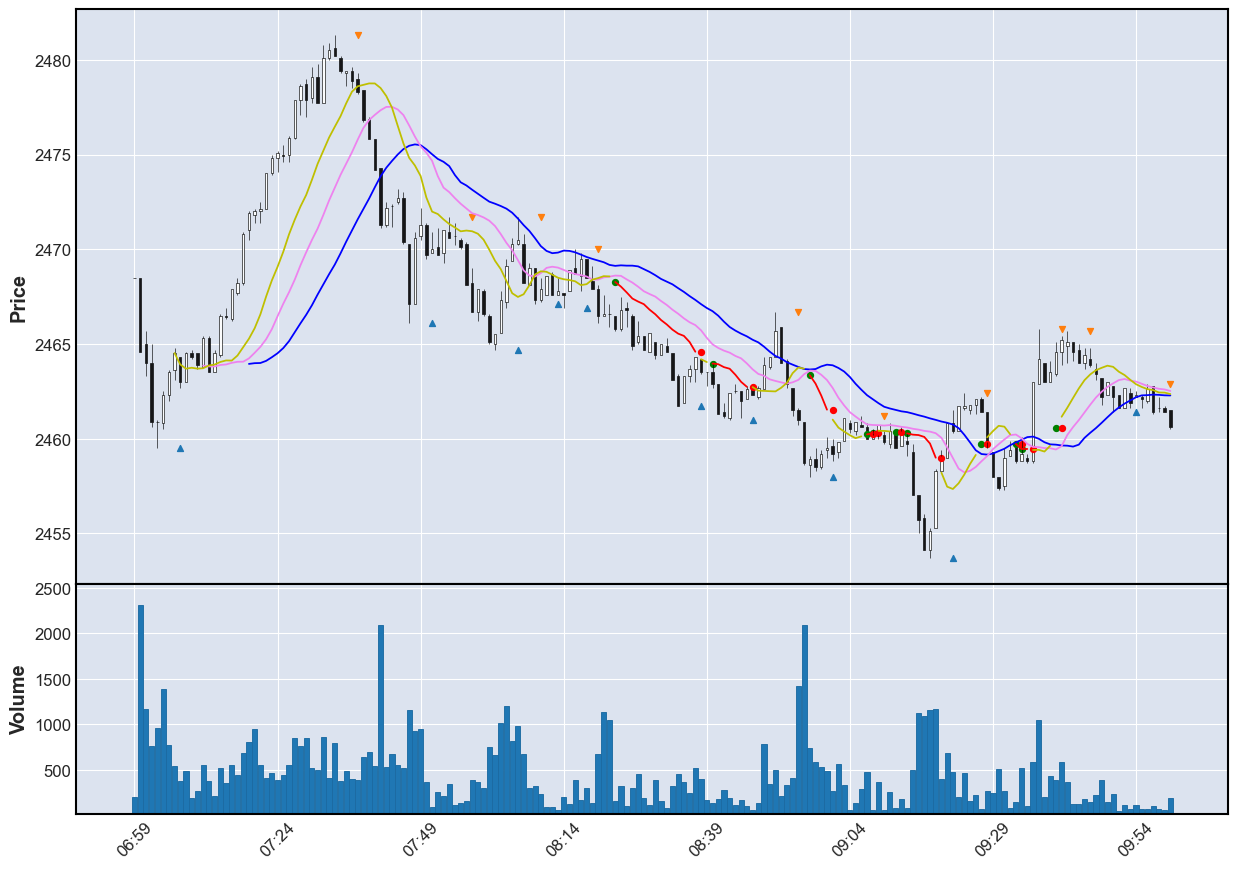

In [15]:

apds = [ mpf.make_addplot(view_data["jaw"],   color="b"),
         mpf.make_addplot(view_data["teeth"], color="violet"),
         mpf.make_addplot(view_data["fractal_bull"],   type='scatter', marker='^'),
         mpf.make_addplot(view_data["fractal_bear"],   type='scatter', marker='v'),
         mpf.make_addplot(view_data["deals_in"],        type='scatter', marker='o', color="g"),
         mpf.make_addplot(view_data["deals_out"],       type='scatter', marker='o', color="r"),
         mpf.make_addplot(view_data["bull_stop_loss"], color="g"),
         mpf.make_addplot(view_data["bear_stop_loss"], color="r"),
         mpf.make_addplot(view_data["no_stop_loss"  ], color="y")
       ]
mpf.plot(view_data, addplot=apds, type='candle', volume=True,figscale=2)

(array([20., 18., 10.,  9.,  8.,  5.,  5.,  4.,  1.,  6.,  4.,  2.,  2.,
         1.,  0.,  3.,  5.,  2.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  2.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.]),
 array([1.31067022e-02, 4.07555288e-01, 8.02003875e-01, 1.19645246e+00,
        1.59090105e+00, 1.98534963e+00, 2.37979822e+00, 2.77424681e+00,
        3.16869539e+00, 3.56314398e+00, 3.95759256e+00, 4.35204115e+00,
        4.74648974e+00, 5.14093832e+00, 5.53538691e+00, 5.92983550e+00,
        6.32428408e+00, 6.71873267e+00, 7.11318125e+00, 7.50762984e+00,
        7.90207843e+00, 8.29652701e+00, 8.69097560e+00, 9.08542419e+00,
        9.47987277e+00, 9.87432136e+00, 1.02687699e+01, 1.06632185e+01,
        1.10576671e+01, 1.14521157e+01, 1.18465643e+01, 1.22410129e+01,
        1.26354615e

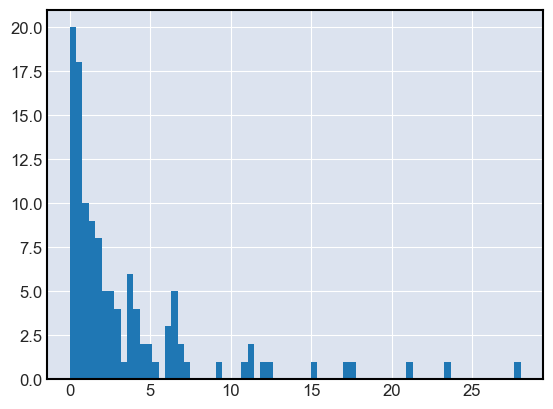

In [16]:
plt.hist([l["value"] for l in losses ], int(np.var([l["value"] for l in losses ])*3))